### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/2_FirstImplementation

### Import libraries

In [ ]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save images in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.05,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4753, 96, 96, 3), y_train shape: (4753, 2)
X_val shape: (251, 96, 96, 3), y_val shape: (251, 2)


### MobileNetV2

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

### Baseline Model

In [ ]:
def build_baseline_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect MobileNetV2 to the input
  x = mobile(inputs)

  # Hidden layers
  x = tfkl.Dense(units=32, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=32, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
baseline = build_baseline_model(mobile, 0.001)
baseline.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 32)                40992     
                                                                 
 HiddenActivation1 (Activat  (None, 32)                0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 32)                1056      
                                                                 
 HiddenActivation2 (Activat  (None, 32)             

In [ ]:
# Train the model
history = baseline.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
266/266 [==============================] - 17s 23ms/step - loss: 0.4664 - accuracy: 0.7762 - val_loss: 0.4011 - val_accuracy: 0.8216
Epoch 2/200
266/266 [==============================] - 3s 11ms/step - loss: 0.3633 - accuracy: 0.8389 - val_loss: 0.4235 - val_accuracy: 0.8123
Epoch 3/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3203 - accuracy: 0.8594 - val_loss: 0.4362 - val_accuracy: 0.8069
Epoch 4/200
266/266 [==============================] - 4s 14ms/step - loss: 0.2889 - accuracy: 0.8773 - val_loss: 0.4151 - val_accuracy: 0.8309
Epoch 5/200
266/266 [==============================] - 3s 11ms/step - loss: 0.2414 - accuracy: 0.9005 - val_loss: 0.4587 - val_accuracy: 0.8109
Epoch 6/200
266/266 [==============================] - 3s 11ms/step - loss: 0.2121 - accuracy: 0.9149 - val_loss: 0.4019 - val_accuracy: 0.8389
Epoch 7/200
266/266 [==============================] - 3s 12ms/step - loss: 0.1706 - accuracy: 0.9335 - val_loss: 0.4849 - val_accuracy

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Model', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Model', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
baseline.save('Baseline')

### Baseline + Dropout

In [ ]:
def build_dropout_model(mobile, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect MobileNetV2 to the input
  x = mobile(inputs)

  # Hidden layers
  x = tfkl.Dense(units=64, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=64, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='dropout_model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
dropout_rate = 1/10

dropout_model = build_dropout_model(mobile, dropout_rate, 0.001)
dropout_model.summary()

Model: "dropout_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 32)                40992     
                                                                 
 HiddenActivation1 (Activat  (None, 32)                0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 HiddenDense2 (Dense)        (None, 32)              

In [ ]:
# Train the model
history_dropout = dropout_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
266/266 [==============================] - 14s 28ms/step - loss: 0.5231 - accuracy: 0.7411 - val_loss: 0.4321 - val_accuracy: 0.8043
Epoch 2/200
266/266 [==============================] - 3s 12ms/step - loss: 0.4089 - accuracy: 0.8154 - val_loss: 0.3843 - val_accuracy: 0.8389
Epoch 3/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3628 - accuracy: 0.8453 - val_loss: 0.3891 - val_accuracy: 0.8229
Epoch 4/200
266/266 [==============================] - 3s 11ms/step - loss: 0.3334 - accuracy: 0.8566 - val_loss: 0.3921 - val_accuracy: 0.8229
Epoch 5/200
266/266 [==============================] - 3s 11ms/step - loss: 0.3027 - accuracy: 0.8643 - val_loss: 0.3973 - val_accuracy: 0.8296
Epoch 6/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2630 - accuracy: 0.8876 - val_loss: 0.4032 - val_accuracy: 0.8189
Epoch 7/200
266/266 [==============================] - 4s 15ms/step - loss: 0.2370 - accuracy: 0.9057 - val_loss: 0.4178 - val_accuracy

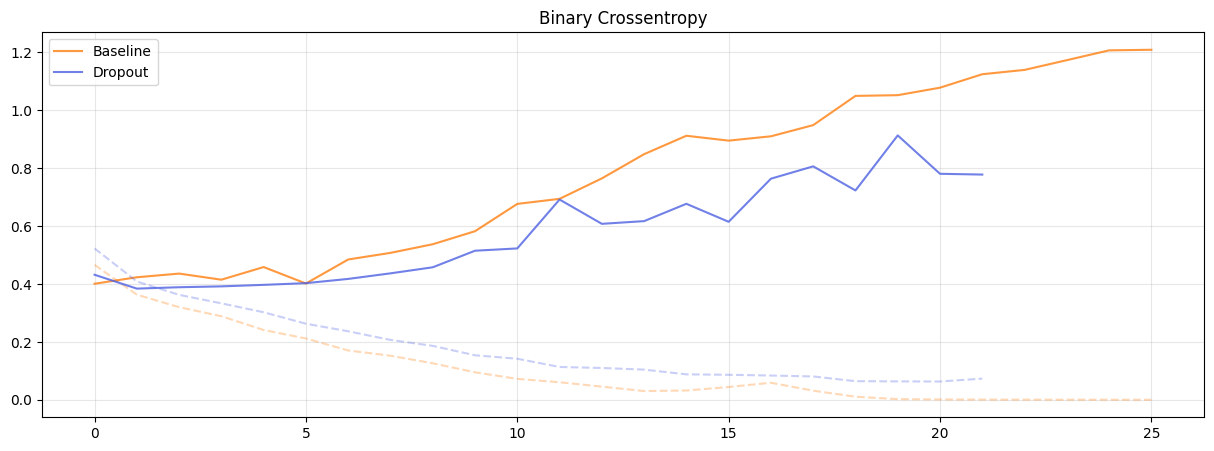

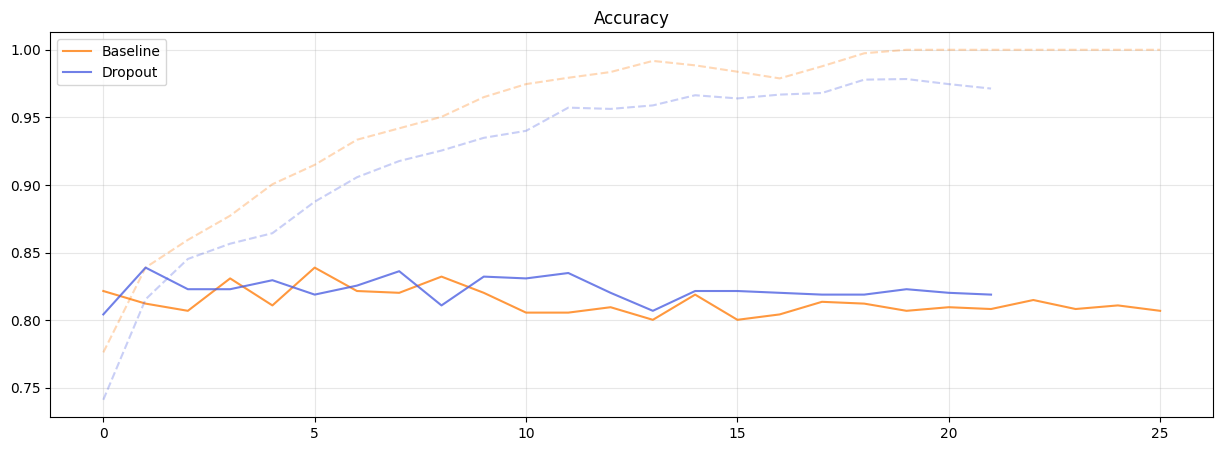

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_dropout['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_dropout['val_loss'], label='Dropout', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_dropout['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_dropout['val_accuracy'], label='Dropout', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
dropout_model.save('Dropout')

### Baseline + Learning rate scheduling

In [ ]:
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [ ]:
lrs_model = build_baseline_model(mobile, 0.001)
lrs_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 32)                40992     
                                                                 
 HiddenActivation1 (Activat  (None, 32)                0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 32)                1056      
                                                                 
 HiddenActivation2 (Activat  (None, 32)             

In [ ]:
# Train the model
history_lrs = lrs_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
266/266 [==============================] - 7s 16ms/step - loss: 0.4868 - accuracy: 0.7684 - val_loss: 0.3880 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 2/200
266/266 [==============================] - 4s 14ms/step - loss: 0.3780 - accuracy: 0.8274 - val_loss: 0.4014 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 3/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3302 - accuracy: 0.8556 - val_loss: 0.4880 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 4/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2821 - accuracy: 0.8726 - val_loss: 0.3909 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 5/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2576 - accuracy: 0.8871 - val_loss: 0.4062 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 6/200
266/266 [==============================] - 3s 13ms/step - loss: 0.2182 - accuracy: 0.9048 - val_loss: 0.4181 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 7/200
266/266 [==============================] - 3s 

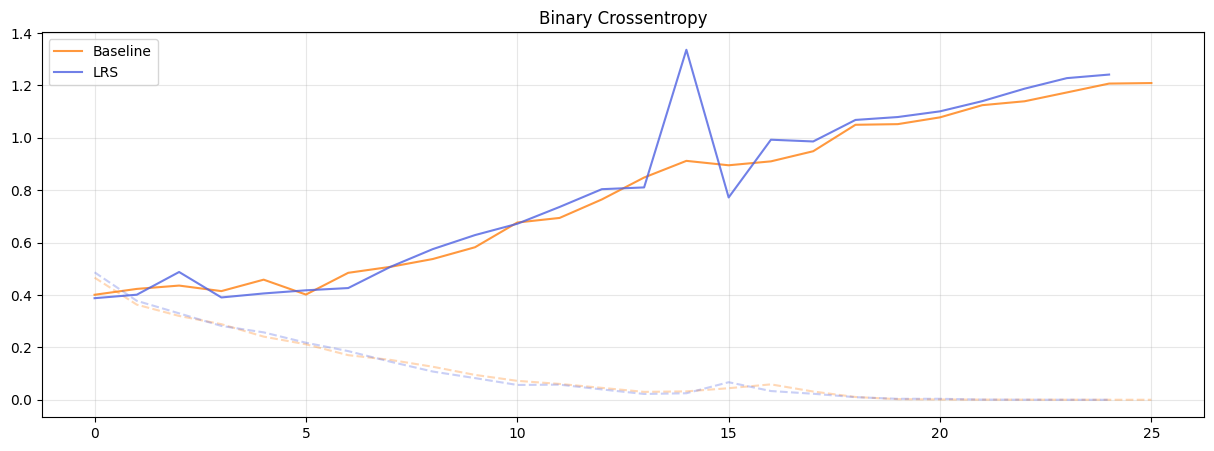

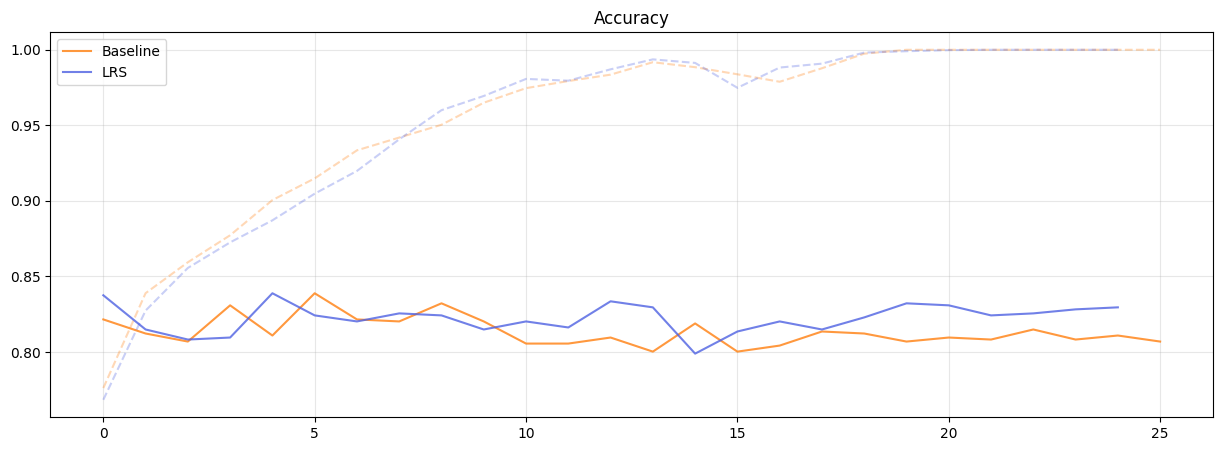

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_lrs['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_lrs['val_loss'], label='LRS', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_lrs['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_lrs['val_accuracy'], label='LRS', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
lrs_model.save('LRS')

### Baseline + LRS + Dropout

In [ ]:
dropout_rate = 1/10

lrs_dropout_model = build_dropout_model(mobile, dropout_rate, 0.001)
lrs_dropout_model.summary()

Model: "dropout_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 32)                40992     
                                                                 
 HiddenActivation1 (Activat  (None, 32)                0         
 ion)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 HiddenDense2 (Dense)        (None, 32)              

In [ ]:
# Train the model
history_lrs_dropout = lrs_dropout_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
266/266 [==============================] - 8s 17ms/step - loss: 0.5236 - accuracy: 0.7414 - val_loss: 0.4121 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 2/200
266/266 [==============================] - 3s 11ms/step - loss: 0.4090 - accuracy: 0.8199 - val_loss: 0.3971 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 3/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3690 - accuracy: 0.8392 - val_loss: 0.4006 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 4/200
266/266 [==============================] - 4s 14ms/step - loss: 0.3361 - accuracy: 0.8566 - val_loss: 0.3969 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 5/200
266/266 [==============================] - 3s 11ms/step - loss: 0.2972 - accuracy: 0.8744 - val_loss: 0.3923 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 6/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2794 - accuracy: 0.8841 - val_loss: 0.4136 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 7/200
266/266 [==============================] - 3s 

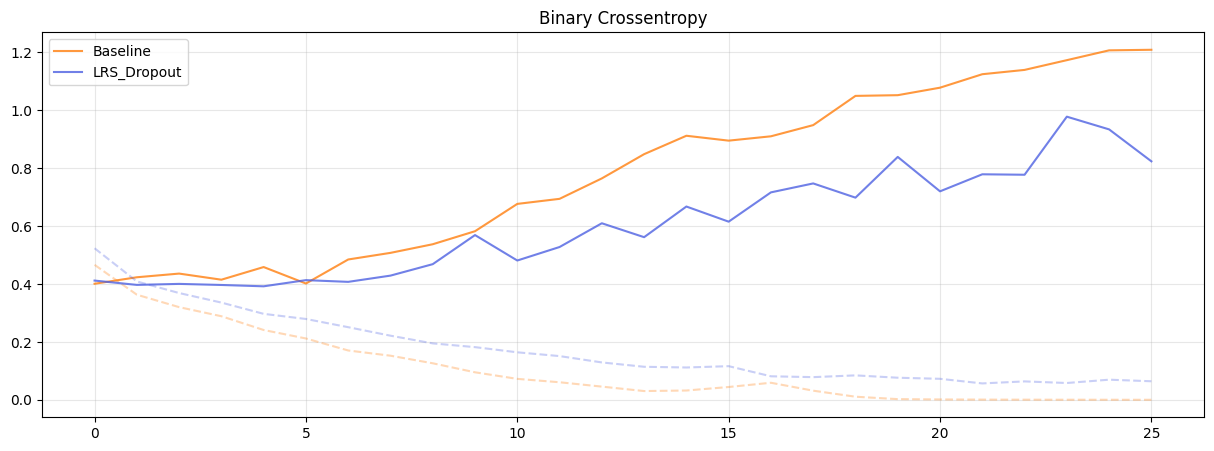

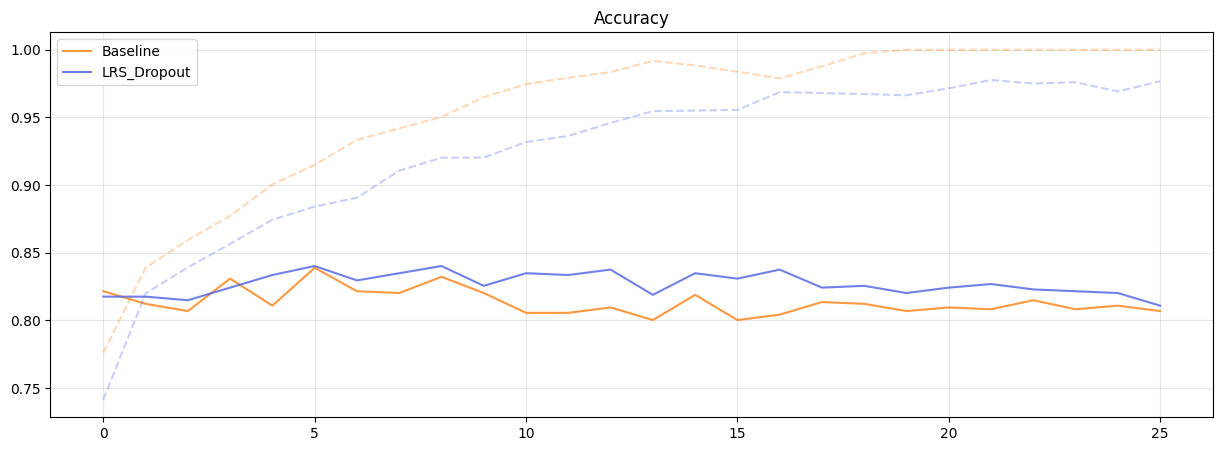

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_lrs_dropout['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_lrs_dropout['val_loss'], label='LRS_Dropout', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_lrs_dropout['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_lrs_dropout['val_accuracy'], label='LRS_Dropout', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
lrs_dropout_model.save('LRS_Dropout')